- Siden deler av kommentarene i denne oppgaven vil være gjeldene for alle delene av oblig3 og 4 vil jeg skrive de samme eller veldig like kommentarer der hvor dette er hensiktsmessig i alle filene for disse oppgavene, men tilføre videre spesifikke kommentarer for den enkelte filen/oppgaven der hvor dette er hensiktsmessig.


In [2]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sb
from sklearn.preprocessing import LabelEncoder, StandardScaler
from sklearn.model_selection import GridSearchCV, StratifiedKFold
from tensorflow.keras.models import Sequential, Model
from tensorflow.keras.layers import Input, Dense, Dropout
from tensorflow.keras.optimizers import Adam, RMSprop
from scikeras.wrappers import KerasRegressor
from sklearn.decomposition import PCA
from sklearn.metrics import r2_score, mean_squared_error, mean_absolute_error
from sklearn.metrics import make_scorer, get_scorer

In [3]:
df = pd.read_csv(r"..\..\oblig3_og_4\abalone.data", sep=",", names=["Sex", "Length", "Diameter", "Height", "Whole weight", "Shucked weight", "Viscera weight", "Shell weight", "Rings"])
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 4177 entries, 0 to 4176
Data columns (total 9 columns):
 #   Column          Non-Null Count  Dtype  
---  ------          --------------  -----  
 0   Sex             4177 non-null   object 
 1   Length          4177 non-null   float64
 2   Diameter        4177 non-null   float64
 3   Height          4177 non-null   float64
 4   Whole weight    4177 non-null   float64
 5   Shucked weight  4177 non-null   float64
 6   Viscera weight  4177 non-null   float64
 7   Shell weight    4177 non-null   float64
 8   Rings           4177 non-null   int64  
dtypes: float64(7), int64(1), object(1)
memory usage: 293.8+ KB


In [4]:
df['Sex'] = pd.Series(np.array(LabelEncoder().fit_transform(df['Sex'])))
features = pd.DataFrame(StandardScaler().fit_transform(df.drop(columns='Rings', axis=1)), columns=df.drop(columns='Rings', axis=1).columns)
targets = df['Rings']

In [5]:
global_random_state = 15

scoring = {
    'mean_absolute_error': make_scorer(mean_absolute_error, greater_is_better=False),
    'mean_squared_error': make_scorer(mean_squared_error, greater_is_better=False),
    'r2': get_scorer('r2'),
}  

def evaluate(estimator, X, y):
    scores = {}
    for (name,scorer) in scoring.items():
        scores[name] = scorer(estimator, X, y) 
    return scores

def train(features, targets, estimator, params, scoring=scoring, refit='r2', random_state=global_random_state, outer_splits=5, inner_splits=4):

    outer_cv = StratifiedKFold(n_splits=outer_splits, shuffle=True, random_state=global_random_state)
    inner_cv = StratifiedKFold(n_splits=inner_splits, shuffle=True, random_state=global_random_state)

    scores_train = []
    scores_test = []
    estimators = []
    cv_results = []

    # Loop through all test folds
    for (train_index, test_index) in outer_cv.split(features, targets):
        
        grid = GridSearchCV(
            estimator,
            params, 
            scoring=scoring, 
            refit=refit,
            error_score='raise', 
            cv=inner_cv)
        grid.fit(features.iloc[train_index], targets.iloc[train_index])        
        
        evaluation_train = evaluate(grid, features.iloc[train_index], targets.iloc[train_index])
        evaluation_test = evaluate(grid, features.iloc[test_index], targets.iloc[test_index])
        
        scores_train.append(evaluation_train)
        scores_test.append(evaluation_test)
        
        estimators.append(grid.best_estimator_)
        cv_results.append(pd.DataFrame(grid.cv_results_))
        print("*")

    return estimators, pd.DataFrame(scores_train), pd.DataFrame(scores_test), pd.concat(cv_results, names=['test_split'], keys=range(outer_splits))

#### Beskrivelser av metoder for trening, tuning og testing av datasettet
- For å test og tune modellene har jeg laget en nested CV funksjon som bruker GridSearchCV som den indre loopen. Ut av denne funksjonen så får vi returnert den beste modellen for hver runde av den ytere loopen, de tilhørende scoring resultatene for både train og test oppsplittingen, og resultatene fra selve GridSearchCV modellen, som blant annet kan brukes til å visualisere parameter tuningen.

- Grunnen til at jeg har valgt å bruke et slik oppsett er at dette tillater meg å trene og tune modellene på hele datasettet uten at modellen overfiter til datasettet som en helhet. Dette gjør at resultatene du får ut fra denne typen validering i større grad vil ha god overførings verdi til hele datasettet for videre bruk.

- Måten dette oppnås på er at datasettet i yter loopen blir delt opp i for eks. 5 deler hvor du bruker 4 av disse dele til trening av modellene og den siste delen til testing. I den indre loopen splitter du igjen opp testdelen av data settet i for eks. 4 deler, hvor da 3 av disse brukes til trening av modellen og 1 del til testing/validering. På denne måte får du benyttet hele datasettet til trening og validering av modellene uten at den enkelte test delen av datasettet har blitt brukt til trening av modellen i forbindelse med sin vurdering av prestasjonen til modellen.

- Jeg har også lagt inn fuksjonalitet for å kunne endre antall spliter i ytter og inner loopene for treningen av modelene, noe som er kan være veldig nytt for å kunne redusere kjøretiden til fuksjonen ved utprøving av forskjellige tuning parameter.

- For oppdelingen av datasettet har jeg bruk StratifiedKFold slik at det oppnå så lik som mulig fordeling av target klassene mellom de forskjellige oppsplittingene av datasettet. Det er imidlertid hvert å merke seg at det for flere av target klassene er veldig få verdier og at det derfor vil være umulig å oppnå en perfekt fordeling. Jeg har imidlertid ikke valgt å gjøre noen tiltak for prøve å balansere ut disse forskjellene i datasettet, da det ikke finnes nok verdier for disse uteligger klassene til å lage sytektisk data. Eller ved å eksskludere disse utligger klassene fra datasettetet vil vi mangle viktig punkter for modellene for å kunne ha god overførings verdi til nye data.  

- For å vurdere disse modellene har jeg valgt å bruke disse metricene "mean absolutte error", "mean squared error" og "r2". r2 er et mål på hvor sterk korrelasjonen mellom de predikerte feature verdieen og target verdiere er. Mean absolute error er et mål på den absolutte feil mengde for prediksjonen til modellene, og gir en indikasjon på hvor mye feil det er i prediksjonene. Mean squared error gir et bilde på hvor bra modellen håndere eventuelle uteligger feil, da disse blir forsterket gjennom kvadreringe i bergningen av feil margien.

- For å unngå eksponentiell kjøretid ved tuningen av modellene kommer jeg til å dele opp tuningen i midre deler slik at kjøretiden blir lettere håndterbar. Utover dette kommer jeg til å gjennomføre noe videre tuning og testing av modellene som ikke vil være inkludert i de endelige fila av hensyn til å gjøre dokumentet mer oversiktig og lett forstålig, men jeg kommer til å dokumentere den helheltlige prossens slik at det mulig å se en rød tråd gjennom tuningen av modellene. 

#### Tensorflow Keras 

-  For alle modellene komm jeg til å bruke linjer (default) som aktiverings fuksjon for output layeret da det er denne som noramlt brukes for regresjons analyser.

- For tuningen av modellene kommer jeg til å fokusere på følgene verdier loss fuksjon ved compliering , aktiverings funksjon for hidden layers, optimizer ved compilering, antall nevroner for 1 og 2 hidden layer, batch size, learing rate for optimizer og dropout for de modellene som inkludere dropout layer.

- Jeg har gjort en grunnleggen sjekk i forkant sli at tuning verdiene jeg starter ikke er for langt unna jeg som blir slutt resultatet. Jeg valg å gjøre dette da parametere som er veldig ulik slutt resultat vil kunne påvirker resultatet for tuningene av de forskjellige parameterene. 

- Det kunne selfølgelig vært implementert endre mere utfylende tuning og utprøving av antall hidden layers, forskjellige activation functions for de individuelle hidden layers osv. Men jeg har valgt å begrense tuningen min til det utvalget jeg har gjort ut fra tidshensyn og det totale omfanget, da jeg mener at dette tilstrekkelig demonstere god forståelse for tuning prosessen og hvilke mulighet det er og hvilke hensyn som bør tas.  

In [6]:
def create_model(optimizer='adam', activation='relu', loss='mean_squared_error', hidden_neurons1=64, hidden_neurons2=32):
    model = Sequential()
    model.add(Input(shape=(8,)))
    model.add(Dense(hidden_neurons1, activation=activation))
    if(hidden_neurons2 > 0):
        model.add(Dense(hidden_neurons2, activation=activation))
    model.add(Dense(8, activation=activation))
    model.add(Dense(1))
    model.compile(optimizer=optimizer, loss=loss, metrics=['mean_squared_error'])
    return model
model_keras_sequential = KerasRegressor(model=create_model, verbose=0)

ref: https://medium.com/@am.benatmane/keras-hyperparameter-tuning-using-sklearn-pipelines-grid-search-with-cross-validation-ccfc74b0ce9f

In [ ]:
keras_reg_param = {
    'batch_size': [20],
    'epochs': [10], 
    'model__hidden_neurons1': [64],
    'model__hidden_neurons2': [32],
    'model__optimizer': ['rmsprop', 'adam'],
    'model__activation': ['relu','sigmoid', 'swish' , 'elu',],
    'model__loss': ['mean_squared_error', 'mean_absolute_error'],
}
keras_reg_estimators, keras_reg_scores_train, keras_reg_scores_test, keras_reg_cv_results = train(features, targets, model_keras_sequential, keras_reg_param, outer_splits=3, inner_splits=3)

c:\Users\hallo\Documents\GitHub\praktisk-maskinlering\.venv\Lib\site-packages\sklearn\model_selection\_split.py:811: UserWarning: The least populated class in y has only 1 members, which is less than n_splits=3.
  warnings.warn(
c:\Users\hallo\Documents\GitHub\praktisk-maskinlering\.venv\Lib\site-packages\sklearn\model_selection\_split.py:811: UserWarning: The least populated class in y has only 1 members, which is less than n_splits=3.
  warnings.warn(


*


c:\Users\hallo\Documents\GitHub\praktisk-maskinlering\.venv\Lib\site-packages\sklearn\model_selection\_split.py:811: UserWarning: The least populated class in y has only 1 members, which is less than n_splits=3.
  warnings.warn(


*


c:\Users\hallo\Documents\GitHub\praktisk-maskinlering\.venv\Lib\site-packages\sklearn\model_selection\_split.py:811: UserWarning: The least populated class in y has only 1 members, which is less than n_splits=3.
  warnings.warn(


*


husk problmer med 'sgd' feil ut pga Nan verdier med denne i bruk.
https://www.geeksforgeeks.org/deep-learning/optimizers-in-tensorflow/


<Axes: xlabel='param_model__loss', ylabel='mean_test_r2'>

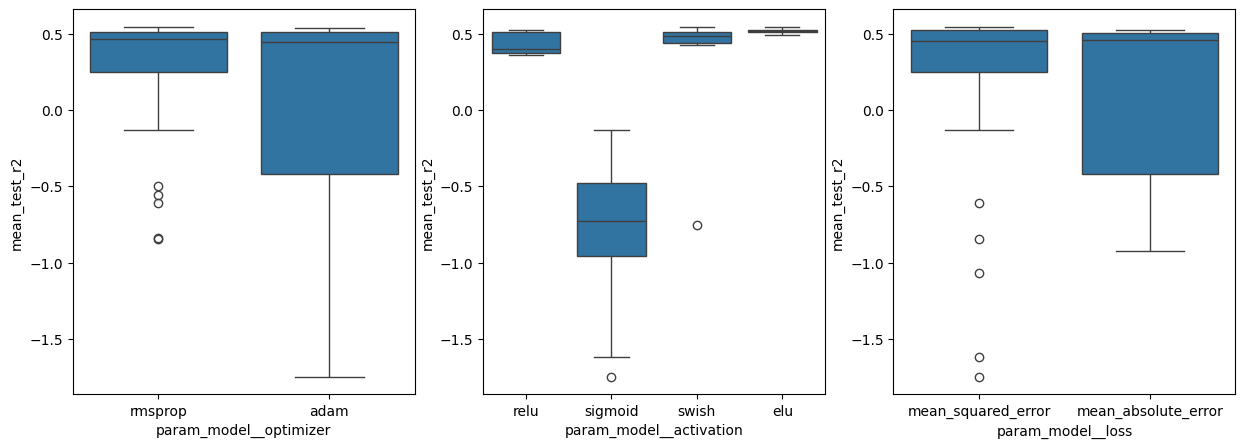

In [7]:
fig, ax = plt.subplots(1,3, figsize=(15,5))
sb.boxplot(data=keras_reg_cv_results, x='param_model__optimizer', y='mean_test_r2', ax=ax[0])
sb.boxplot(data=keras_reg_cv_results, x='param_model__activation', y='mean_test_r2', ax=ax[1])
sb.boxplot(data=keras_reg_cv_results, x='param_model__loss', y='mean_test_r2', ax=ax[2])

ut i fra resultatene i den første velger jeg å fjerne adagrad.... og sigmoid

In [8]:
keras_reg_scores_test.describe()

,mean_absolute_error,mean_squared_error,r2
count,3.000000,3.000000,3.000000
mean,-1.629127,-5.091338,0.509956
std,0.097281,0.345442,0.035227
min,-1.741382,-5.474923,0.473833
25%,-1.658968,-5.234609,0.492828
50%,-1.576553,-4.994294,0.511822
75%,-1.572999,-4.899545,0.528018
max,-1.569444,-4.804797,0.544213


In [9]:
keras_reg_scores_train.describe()

,mean_absolute_error,mean_squared_error,r2
count,3.000000,3.000000,3.000000
mean,-1.599710,-4.966483,0.522283
std,0.098634,0.432580,0.038654
min,-1.713143,-5.253432,0.498413
25%,-1.632497,-5.215259,0.499985
50%,-1.551851,-5.177085,0.501557
75%,-1.542994,-4.823008,0.534219
max,-1.534137,-4.468931,0.566880


In [10]:
keras_reg_estimators

[KerasRegressor(
 	model=<function create_model at 0x000001E9E318E200>
 	build_fn=None
 	warm_start=False
 	random_state=None
 	optimizer=rmsprop
 	loss=None
 	metrics=None
 	batch_size=20
 	validation_batch_size=None
 	verbose=0
 	callbacks=None
 	validation_split=0.0
 	shuffle=True
 	run_eagerly=False
 	epochs=10
 	model__activation=elu
 	model__hidden_neurons1=64
 	model__hidden_neurons2=32
 	model__loss=mean_squared_error
 	model__optimizer=adam
 ),
 KerasRegressor(
 	model=<function create_model at 0x000001E9E318E200>
 	build_fn=None
 	warm_start=False
 	random_state=None
 	optimizer=rmsprop
 	loss=None
 	metrics=None
 	batch_size=20
 	validation_batch_size=None
 	verbose=0
 	callbacks=None
 	validation_split=0.0
 	shuffle=True
 	run_eagerly=False
 	epochs=10
 	model__activation=elu
 	model__hidden_neurons1=64
 	model__hidden_neurons2=32
 	model__loss=mean_absolute_error
 	model__optimizer=rmsprop
 ),
 KerasRegressor(
 	model=<function create_model at 0x000001E9E318E200>
 	build_f

In [11]:
keras_reg_param = {
    'batch_size': [20],
    'epochs': [10], 
    'model__hidden_neurons1': [64],
    'model__hidden_neurons2': [32],
    'model__optimizer': ['rmsprop', 'adam'],
    'model__activation': ['relu', 'swish' , 'elu',],
    'model__loss': ['mean_squared_error', 'mean_absolute_error'],
}
keras_reg_estimators2, keras_reg_scores_train2, keras_reg_scores_test2, keras_reg_cv_results2 = train(features, targets, model_keras_sequential, keras_reg_param, outer_splits=5, inner_splits=4)

c:\Users\hallo\Documents\GitHub\praktisk-maskinlering\.venv\Lib\site-packages\sklearn\model_selection\_split.py:811: UserWarning: The least populated class in y has only 1 members, which is less than n_splits=5.
  warnings.warn(
c:\Users\hallo\Documents\GitHub\praktisk-maskinlering\.venv\Lib\site-packages\sklearn\model_selection\_split.py:811: UserWarning: The least populated class in y has only 1 members, which is less than n_splits=4.
  warnings.warn(


*


c:\Users\hallo\Documents\GitHub\praktisk-maskinlering\.venv\Lib\site-packages\sklearn\model_selection\_split.py:811: UserWarning: The least populated class in y has only 1 members, which is less than n_splits=4.
  warnings.warn(


*


c:\Users\hallo\Documents\GitHub\praktisk-maskinlering\.venv\Lib\site-packages\sklearn\model_selection\_split.py:811: UserWarning: The least populated class in y has only 1 members, which is less than n_splits=4.
  warnings.warn(


*


c:\Users\hallo\Documents\GitHub\praktisk-maskinlering\.venv\Lib\site-packages\sklearn\model_selection\_split.py:811: UserWarning: The least populated class in y has only 1 members, which is less than n_splits=4.
  warnings.warn(


*


c:\Users\hallo\Documents\GitHub\praktisk-maskinlering\.venv\Lib\site-packages\sklearn\model_selection\_split.py:811: UserWarning: The least populated class in y has only 1 members, which is less than n_splits=4.
  warnings.warn(


*


<Axes: xlabel='param_model__loss', ylabel='mean_test_r2'>

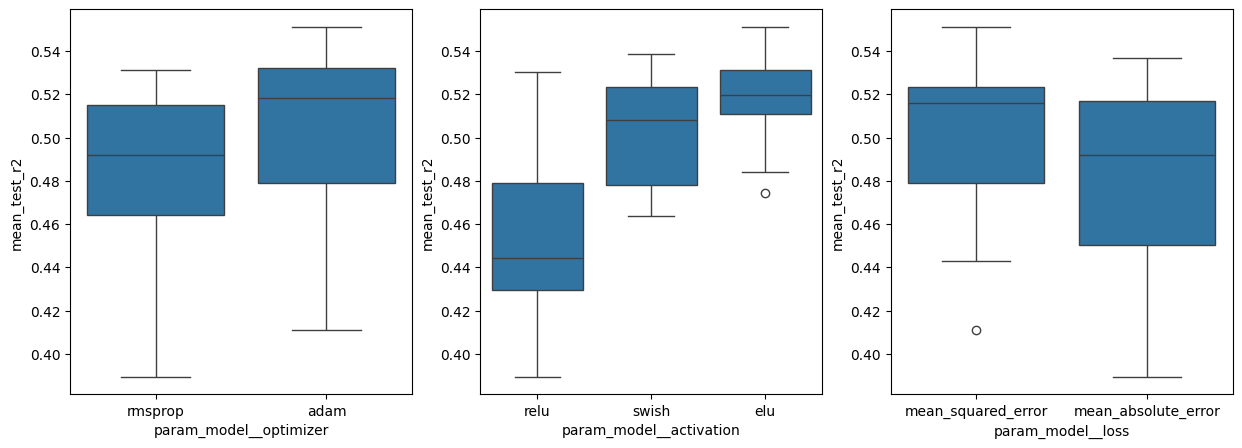

In [12]:
fig, ax = plt.subplots(1,3, figsize=(15,5))
sb.boxplot(data=keras_reg_cv_results2, x='param_model__optimizer', y='mean_test_r2', ax=ax[0])
sb.boxplot(data=keras_reg_cv_results2, x='param_model__activation', y='mean_test_r2', ax=ax[1])
sb.boxplot(data=keras_reg_cv_results2, x='param_model__loss', y='mean_test_r2', ax=ax[2])

In [13]:
keras_reg_scores_test2.describe()

,mean_absolute_error,mean_squared_error,r2
count,5.000000,5.000000,5.000000
mean,-1.551547,-4.917063,0.526559
std,0.026887,0.704066,0.070601
min,-1.584510,-6.129230,0.402017
25%,-1.566125,-4.919151,0.541654
50%,-1.552606,-4.584141,0.553380
75%,-1.541572,-4.560869,0.562098
max,-1.512921,-4.391924,0.573644


In [14]:
keras_reg_scores_train2.describe()

,mean_absolute_error,mean_squared_error,r2
count,5.000000,5.000000,5.000000
mean,-1.530246,-4.524284,0.564675
std,0.012521,0.040293,0.002295
min,-1.542168,-4.566877,0.561927
25%,-1.540500,-4.549626,0.563196
50%,-1.534827,-4.541460,0.564508
75%,-1.517508,-4.489509,0.565959
max,-1.516225,-4.473950,0.567782


In [15]:
keras_reg_estimators2

[KerasRegressor(
 	model=<function create_model at 0x000001E9E318E200>
 	build_fn=None
 	warm_start=False
 	random_state=None
 	optimizer=rmsprop
 	loss=None
 	metrics=None
 	batch_size=20
 	validation_batch_size=None
 	verbose=0
 	callbacks=None
 	validation_split=0.0
 	shuffle=True
 	run_eagerly=False
 	epochs=10
 	model__activation=elu
 	model__hidden_neurons1=64
 	model__hidden_neurons2=32
 	model__loss=mean_squared_error
 	model__optimizer=adam
 ),
 KerasRegressor(
 	model=<function create_model at 0x000001E9E318E200>
 	build_fn=None
 	warm_start=False
 	random_state=None
 	optimizer=rmsprop
 	loss=None
 	metrics=None
 	batch_size=20
 	validation_batch_size=None
 	verbose=0
 	callbacks=None
 	validation_split=0.0
 	shuffle=True
 	run_eagerly=False
 	epochs=10
 	model__activation=elu
 	model__hidden_neurons1=64
 	model__hidden_neurons2=32
 	model__loss=mean_squared_error
 	model__optimizer=adam
 ),
 KerasRegressor(
 	model=<function create_model at 0x000001E9E318E200>
 	build_fn=No

In [7]:
keras_reg_param = {
    'batch_size': [20],
    'epochs': [10], 
    'model__hidden_neurons1': [64, 128, 192],
    'model__hidden_neurons2': [32, 48, 64],   
    'model__optimizer': ['adam'],
    'model__activation': ['elu',],
    'model__loss': ['mean_squared_error'],
}
keras_reg_estimators3, keras_reg_scores_train3, keras_reg_scores_test3, keras_reg_cv_results3 = train(features, targets, model_keras_sequential, keras_reg_param, outer_splits=5, inner_splits=4)

c:\Users\hallo\Documents\GitHub\praktisk-maskinlering\.venv\Lib\site-packages\sklearn\model_selection\_split.py:811: UserWarning: The least populated class in y has only 1 members, which is less than n_splits=5.
  warnings.warn(
c:\Users\hallo\Documents\GitHub\praktisk-maskinlering\.venv\Lib\site-packages\sklearn\model_selection\_split.py:811: UserWarning: The least populated class in y has only 1 members, which is less than n_splits=4.
  warnings.warn(


*


c:\Users\hallo\Documents\GitHub\praktisk-maskinlering\.venv\Lib\site-packages\sklearn\model_selection\_split.py:811: UserWarning: The least populated class in y has only 1 members, which is less than n_splits=4.
  warnings.warn(


*


c:\Users\hallo\Documents\GitHub\praktisk-maskinlering\.venv\Lib\site-packages\sklearn\model_selection\_split.py:811: UserWarning: The least populated class in y has only 1 members, which is less than n_splits=4.
  warnings.warn(


*


c:\Users\hallo\Documents\GitHub\praktisk-maskinlering\.venv\Lib\site-packages\sklearn\model_selection\_split.py:811: UserWarning: The least populated class in y has only 1 members, which is less than n_splits=4.
  warnings.warn(


*


c:\Users\hallo\Documents\GitHub\praktisk-maskinlering\.venv\Lib\site-packages\sklearn\model_selection\_split.py:811: UserWarning: The least populated class in y has only 1 members, which is less than n_splits=4.
  warnings.warn(


*


<Axes: xlabel='param_model__hidden_neurons2', ylabel='mean_test_r2'>

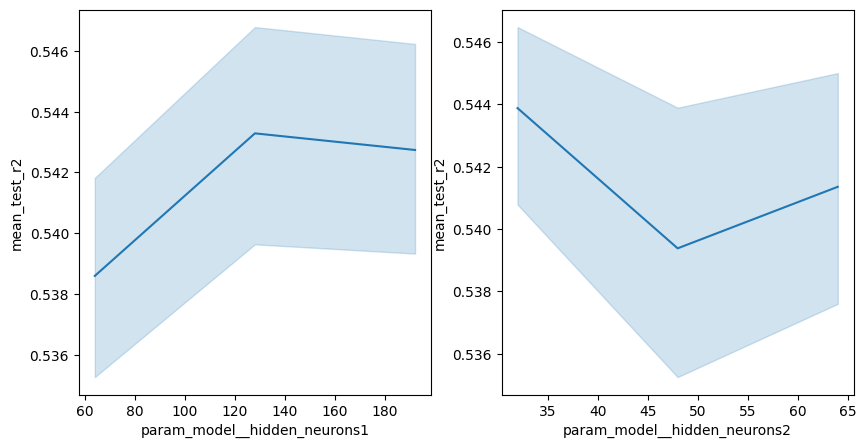

In [8]:
fig, ax = plt.subplots(1,2, figsize=(10,5))
sb.lineplot(data=keras_reg_cv_results3, x='param_model__hidden_neurons1', y='mean_test_r2', ax=ax[0])
sb.lineplot(data=keras_reg_cv_results3, x='param_model__hidden_neurons2', y='mean_test_r2', ax=ax[1])

In [9]:
keras_reg_scores_test3.describe()

,mean_absolute_error,mean_squared_error,r2
count,5.000000,5.000000,5.000000
mean,-1.546433,-4.617443,0.555795
std,0.039110,0.219415,0.016209
min,-1.597072,-4.886871,0.539509
25%,-1.576367,-4.719956,0.544661
50%,-1.537682,-4.692358,0.549474
75%,-1.511532,-4.438838,0.567537
max,-1.509511,-4.349192,0.577792


In [10]:
keras_reg_scores_train3.describe()

,mean_absolute_error,mean_squared_error,r2
count,5.000000,5.000000,5.000000
mean,-1.530696,-4.510883,0.565961
std,0.029786,0.067083,0.005965
min,-1.565287,-4.573881,0.559660
25%,-1.549416,-4.565378,0.562215
50%,-1.539177,-4.536857,0.564422
75%,-1.503028,-4.446061,0.568664
max,-1.496573,-4.432236,0.574843


In [12]:
keras_reg_estimators3

[KerasRegressor(
 	model=<function create_model at 0x000001FE3F93E160>
 	build_fn=None
 	warm_start=False
 	random_state=None
 	optimizer=rmsprop
 	loss=None
 	metrics=None
 	batch_size=20
 	validation_batch_size=None
 	verbose=0
 	callbacks=None
 	validation_split=0.0
 	shuffle=True
 	run_eagerly=False
 	epochs=10
 	model__activation=elu
 	model__hidden_neurons1=128
 	model__hidden_neurons2=32
 	model__loss=mean_squared_error
 	model__optimizer=adam
 ),
 KerasRegressor(
 	model=<function create_model at 0x000001FE3F93E160>
 	build_fn=None
 	warm_start=False
 	random_state=None
 	optimizer=rmsprop
 	loss=None
 	metrics=None
 	batch_size=20
 	validation_batch_size=None
 	verbose=0
 	callbacks=None
 	validation_split=0.0
 	shuffle=True
 	run_eagerly=False
 	epochs=10
 	model__activation=elu
 	model__hidden_neurons1=128
 	model__hidden_neurons2=32
 	model__loss=mean_squared_error
 	model__optimizer=adam
 ),
 KerasRegressor(
 	model=<function create_model at 0x000001FE3F93E160>
 	build_fn=

In [14]:
keras_reg_param = {
    'batch_size': [20],
    'epochs': [10], 
    'model__hidden_neurons1': [128, 160, 192],
    'model__hidden_neurons2': [24, 32],   
    'model__optimizer': ['adam'],
    'model__activation': ['elu',],
    'model__loss': ['mean_squared_error'],
}
keras_reg_estimators4, keras_reg_scores_train4, keras_reg_scores_test4, keras_reg_cv_results4 = train(features, targets, model_keras_sequential, keras_reg_param, outer_splits=5, inner_splits=4)

c:\Users\hallo\Documents\GitHub\praktisk-maskinlering\.venv\Lib\site-packages\sklearn\model_selection\_split.py:811: UserWarning: The least populated class in y has only 1 members, which is less than n_splits=5.
  warnings.warn(
c:\Users\hallo\Documents\GitHub\praktisk-maskinlering\.venv\Lib\site-packages\sklearn\model_selection\_split.py:811: UserWarning: The least populated class in y has only 1 members, which is less than n_splits=4.
  warnings.warn(


*


c:\Users\hallo\Documents\GitHub\praktisk-maskinlering\.venv\Lib\site-packages\sklearn\model_selection\_split.py:811: UserWarning: The least populated class in y has only 1 members, which is less than n_splits=4.
  warnings.warn(


*


c:\Users\hallo\Documents\GitHub\praktisk-maskinlering\.venv\Lib\site-packages\sklearn\model_selection\_split.py:811: UserWarning: The least populated class in y has only 1 members, which is less than n_splits=4.
  warnings.warn(


*


c:\Users\hallo\Documents\GitHub\praktisk-maskinlering\.venv\Lib\site-packages\sklearn\model_selection\_split.py:811: UserWarning: The least populated class in y has only 1 members, which is less than n_splits=4.
  warnings.warn(


*


c:\Users\hallo\Documents\GitHub\praktisk-maskinlering\.venv\Lib\site-packages\sklearn\model_selection\_split.py:811: UserWarning: The least populated class in y has only 1 members, which is less than n_splits=4.
  warnings.warn(


*


<Axes: xlabel='param_model__hidden_neurons2', ylabel='mean_test_r2'>

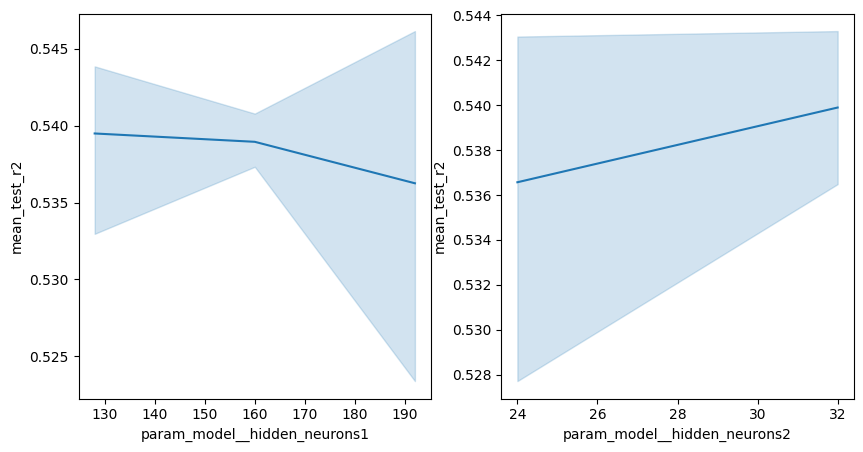

In [21]:
fig, ax = plt.subplots(1,2, figsize=(10,5))
sb.lineplot(data=keras_reg_cv_results4, x='param_model__hidden_neurons1', y='mean_test_r2', ax=ax[0])
sb.lineplot(data=keras_reg_cv_results4, x='param_model__hidden_neurons2', y='mean_test_r2', ax=ax[1])

In [17]:
keras_reg_scores_test4.describe()

,mean_absolute_error,mean_squared_error,r2
count,5.000000,5.000000,5.000000
mean,-1.563036,-4.654319,0.552187
std,0.046812,0.177011,0.013133
min,-1.638215,-4.859519,0.543190
25%,-1.575308,-4.712507,0.547210
50%,-1.550349,-4.682228,0.547539
75%,-1.527538,-4.644009,0.547548
max,-1.523771,-4.373333,0.575449


In [18]:
keras_reg_scores_train4.describe()

,mean_absolute_error,mean_squared_error,r2
count,5.000000,5.000000,5.000000
mean,-1.545625,-4.539868,0.563194
std,0.031910,0.125361,0.010767
min,-1.589428,-4.696111,0.549531
25%,-1.555541,-4.623866,0.554847
50%,-1.548921,-4.517219,0.566833
75%,-1.531604,-4.491107,0.568814
max,-1.502631,-4.371038,0.575943


In [22]:
keras_reg_estimators4

[KerasRegressor(
 	model=<function create_model at 0x000001FE3F93E160>
 	build_fn=None
 	warm_start=False
 	random_state=None
 	optimizer=rmsprop
 	loss=None
 	metrics=None
 	batch_size=20
 	validation_batch_size=None
 	verbose=0
 	callbacks=None
 	validation_split=0.0
 	shuffle=True
 	run_eagerly=False
 	epochs=10
 	model__activation=elu
 	model__hidden_neurons1=192
 	model__hidden_neurons2=32
 	model__loss=mean_squared_error
 	model__optimizer=adam
 ),
 KerasRegressor(
 	model=<function create_model at 0x000001FE3F93E160>
 	build_fn=None
 	warm_start=False
 	random_state=None
 	optimizer=rmsprop
 	loss=None
 	metrics=None
 	batch_size=20
 	validation_batch_size=None
 	verbose=0
 	callbacks=None
 	validation_split=0.0
 	shuffle=True
 	run_eagerly=False
 	epochs=10
 	model__activation=elu
 	model__hidden_neurons1=128
 	model__hidden_neurons2=24
 	model__loss=mean_squared_error
 	model__optimizer=adam
 ),
 KerasRegressor(
 	model=<function create_model at 0x000001FE3F93E160>
 	build_fn=

In [24]:
def create_model2(activation='relu', loss='mean_squared_error', hidden_neurons1=64, hidden_neurons2=32, learning_rate=0.001):
    model = Sequential()
    model.add(Input(shape=(8,)))
    model.add(Dense(hidden_neurons1, activation=activation))
    if(hidden_neurons2 > 0):
        model.add(Dense(hidden_neurons2, activation=activation))
    model.add(Dense(8, activation=activation))
    model.add(Dense(1))
    model.compile(optimizer=Adam(learning_rate=learning_rate), loss=loss, metrics=['mean_squared_error'])
    return model

fortsett her.......

In [25]:
keras_reg_param = {
    'batch_size': [5, 10, 20],
    'epochs': [10], 
    'model__hidden_neurons1': [128],
    'model__hidden_neurons2': [32],
    'model__activation': ['elu'],
    'model__loss': ['mean_squared_error'],
    'model__learning_rate': [0.0005, 0.001, 0.005, 0.01],
}
model_keras_sequential_2 = KerasRegressor(create_model2, verbose=0)
keras_reg_estimators5, keras_reg_scores_train5, keras_reg_scores_test5, keras_reg_cv_results5 = train(features, targets, model_keras_sequential_2, keras_reg_param, outer_splits=5, inner_splits=4)

c:\Users\hallo\Documents\GitHub\praktisk-maskinlering\.venv\Lib\site-packages\sklearn\model_selection\_split.py:811: UserWarning: The least populated class in y has only 1 members, which is less than n_splits=5.
  warnings.warn(
c:\Users\hallo\Documents\GitHub\praktisk-maskinlering\.venv\Lib\site-packages\sklearn\model_selection\_split.py:811: UserWarning: The least populated class in y has only 1 members, which is less than n_splits=4.
  warnings.warn(


KeyboardInterrupt: 

<Axes: xlabel='param_model__learning_rate', ylabel='mean_test_r2'>

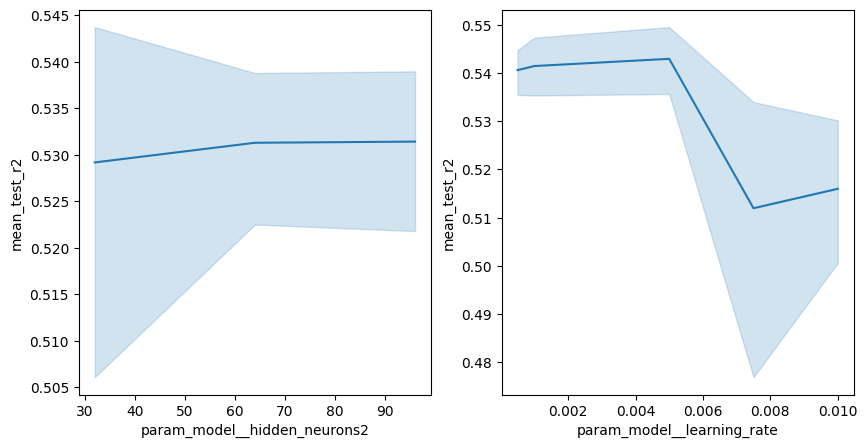

In [28]:
fig, ax = plt.subplots(1,2, figsize=(10,5))
sb.lineplot(data=keras_reg_cv_results5, x='param_model__hidden_neurons2', y='mean_test_r2', ax=ax[0])
sb.lineplot(data=keras_reg_cv_results5, x='param_model__learning_rate', y='mean_test_r2', ax=ax[1])

In [29]:
keras_reg_scores_test5.describe()

,mean_absolute_error,mean_squared_error,r2
count,5.000000,5.000000,5.000000
mean,-1.571576,-4.792773,0.538968
std,0.050843,0.356781,0.030661
min,-1.624885,-5.251364,0.495802
25%,-1.624085,-5.004327,0.533717
50%,-1.562173,-4.707616,0.540713
75%,-1.524839,-4.694896,0.542590
max,-1.521896,-4.305661,0.582018


In [30]:
keras_reg_scores_train5.describe()

,mean_absolute_error,mean_squared_error,r2
count,5.000000,5.000000,5.000000
mean,-1.555711,-4.552347,0.561982
std,0.054365,0.122715,0.011020
min,-1.620654,-4.707289,0.546816
25%,-1.596281,-4.650859,0.553872
50%,-1.555535,-4.506503,0.567860
75%,-1.517373,-4.486440,0.569262
max,-1.488711,-4.410645,0.572100


In [31]:
keras_reg_estimators5

[KerasRegressor(
 	model=<function create_model2 at 0x000001EB08A20AE0>
 	build_fn=None
 	warm_start=False
 	random_state=None
 	optimizer=rmsprop
 	loss=None
 	metrics=None
 	batch_size=10
 	validation_batch_size=None
 	verbose=0
 	callbacks=None
 	validation_split=0.0
 	shuffle=True
 	run_eagerly=False
 	epochs=10
 	model__activation=elu
 	model__hidden_neurons1=160
 	model__hidden_neurons2=64
 	model__learning_rate=0.001
 	model__loss=mean_squared_error
 ),
 KerasRegressor(
 	model=<function create_model2 at 0x000001EB08A20AE0>
 	build_fn=None
 	warm_start=False
 	random_state=None
 	optimizer=rmsprop
 	loss=None
 	metrics=None
 	batch_size=10
 	validation_batch_size=None
 	verbose=0
 	callbacks=None
 	validation_split=0.0
 	shuffle=True
 	run_eagerly=False
 	epochs=10
 	model__activation=elu
 	model__hidden_neurons1=160
 	model__hidden_neurons2=32
 	model__learning_rate=0.001
 	model__loss=mean_squared_error
 ),
 KerasRegressor(
 	model=<function create_model2 at 0x000001EB08A20AE0

In [90]:
keras_reg_param = {
    'batch_size': [10],
    'epochs': [10], 
    'model__hidden_neurons1': [160],
    'model__hidden_neurons2': [32],
    'model__activation': ['elu'],
    'model__loss': ['mean_squared_error'],
    'model__learning_rate': [0.005],
}
keras_sequential_estimators_final, keras_sequential_scores_train_final, keras_sequential_scores_test_final, keras_sequential_cv_results_final = train(features, targets, model_keras_sequential_2, keras_reg_param, outer_splits=5, inner_splits=4)

c:\Users\hallo\Documents\GitHub\praktisk-maskinlering\.venv\Lib\site-packages\sklearn\model_selection\_split.py:811: UserWarning: The least populated class in y has only 1 members, which is less than n_splits=5.
  warnings.warn(
c:\Users\hallo\Documents\GitHub\praktisk-maskinlering\.venv\Lib\site-packages\sklearn\model_selection\_split.py:811: UserWarning: The least populated class in y has only 1 members, which is less than n_splits=4.
  warnings.warn(


*


c:\Users\hallo\Documents\GitHub\praktisk-maskinlering\.venv\Lib\site-packages\sklearn\model_selection\_split.py:811: UserWarning: The least populated class in y has only 1 members, which is less than n_splits=4.
  warnings.warn(


*


c:\Users\hallo\Documents\GitHub\praktisk-maskinlering\.venv\Lib\site-packages\sklearn\model_selection\_split.py:811: UserWarning: The least populated class in y has only 1 members, which is less than n_splits=4.
  warnings.warn(


*


c:\Users\hallo\Documents\GitHub\praktisk-maskinlering\.venv\Lib\site-packages\sklearn\model_selection\_split.py:811: UserWarning: The least populated class in y has only 1 members, which is less than n_splits=4.
  warnings.warn(


*


c:\Users\hallo\Documents\GitHub\praktisk-maskinlering\.venv\Lib\site-packages\sklearn\model_selection\_split.py:811: UserWarning: The least populated class in y has only 1 members, which is less than n_splits=4.
  warnings.warn(


*


In [91]:
keras_sequential_scores_test_final.describe()

,mean_absolute_error,mean_squared_error,r2
count,5.000000,5.000000,5.000000
mean,-1.626969,-5.445882,0.475847
std,0.124923,1.134637,0.110558
min,-1.783437,-7.386076,0.282980
25%,-1.725044,-5.356860,0.498749
50%,-1.582821,-5.220674,0.500870
75%,-1.567818,-4.681527,0.543892
max,-1.475727,-4.584274,0.552747


In [92]:
keras_sequential_scores_train_final.describe()

,mean_absolute_error,mean_squared_error,r2
count,5.000000,5.000000,5.000000
mean,-1.597413,-4.934826,0.525084
std,0.119098,0.394831,0.039139
min,-1.759283,-5.264753,0.493572
25%,-1.681524,-5.260344,0.494538
50%,-1.541794,-5.131045,0.502211
75%,-1.535758,-4.570571,0.561573
max,-1.468704,-4.447415,0.573527


#### Keras Sequential

- For denne modellen har valgt å inkludere 3 hidden layers i tilleg til input og output layers. For 2 av disse har jeg lagt inn muligheten for tuning av antall nevroner, mens for det siste layeret har jeg ikke inkuldert noen mulighet for dette.

- 

In [32]:
def create_model3(activation='elu', loss='mean_squared_error', hidden_neurons1=160, hidden_neurons2=32, dropout=0.1):
    model = Sequential()
    model.add(Input(shape=(8,)))
    model.add(Dense(hidden_neurons1, activation=activation))
    if(dropout > 0):
        model.add(Dropout(dropout))
    model.add(Dense(hidden_neurons2, activation=activation))
    model.add(Dense(8, activation=activation))
    model.add(Dense(1))
    model.compile(optimizer=Adam(learning_rate=0.005), loss=loss, metrics=['mean_squared_error'])
    return model

In [33]:
keras_reg_param = {
    'batch_size': [10],
    'epochs': [10],
    'model__dropout':[0.01, 0.1, 0.15, 0.2],
    'model__hidden_neurons2': [32],
}
model_keras_sequential_dropout = KerasRegressor(create_model3, verbose=0)
keras_reg_estimators6, keras_reg_scores_train6, keras_reg_scores_test6, keras_reg_cv_results6 = train(features, targets, model_keras_sequential_dropout, keras_reg_param, outer_splits=5, inner_splits=4)

c:\Users\hallo\Documents\GitHub\praktisk-maskinlering\.venv\Lib\site-packages\sklearn\model_selection\_split.py:811: UserWarning: The least populated class in y has only 1 members, which is less than n_splits=5.
  warnings.warn(
c:\Users\hallo\Documents\GitHub\praktisk-maskinlering\.venv\Lib\site-packages\sklearn\model_selection\_split.py:811: UserWarning: The least populated class in y has only 1 members, which is less than n_splits=4.
  warnings.warn(


*


c:\Users\hallo\Documents\GitHub\praktisk-maskinlering\.venv\Lib\site-packages\sklearn\model_selection\_split.py:811: UserWarning: The least populated class in y has only 1 members, which is less than n_splits=4.
  warnings.warn(


*


c:\Users\hallo\Documents\GitHub\praktisk-maskinlering\.venv\Lib\site-packages\sklearn\model_selection\_split.py:811: UserWarning: The least populated class in y has only 1 members, which is less than n_splits=4.
  warnings.warn(


*


c:\Users\hallo\Documents\GitHub\praktisk-maskinlering\.venv\Lib\site-packages\sklearn\model_selection\_split.py:811: UserWarning: The least populated class in y has only 1 members, which is less than n_splits=4.
  warnings.warn(


*


c:\Users\hallo\Documents\GitHub\praktisk-maskinlering\.venv\Lib\site-packages\sklearn\model_selection\_split.py:811: UserWarning: The least populated class in y has only 1 members, which is less than n_splits=4.
  warnings.warn(


*


<Axes: xlabel='param_model__dropout', ylabel='mean_test_r2'>

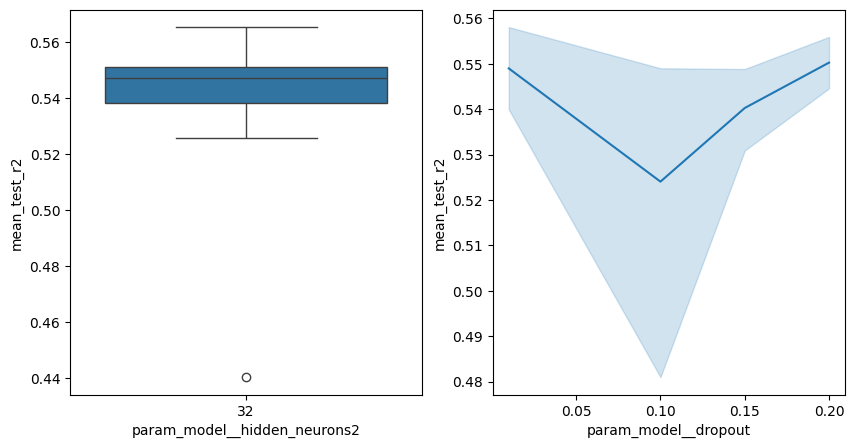

In [34]:
fig, ax = plt.subplots(1,2, figsize=(10,5))
sb.boxplot(data=keras_reg_cv_results6, x='param_model__hidden_neurons2', y='mean_test_r2', ax=ax[0])
sb.lineplot(data=keras_reg_cv_results6, x='param_model__dropout', y='mean_test_r2', ax=ax[1])

In [35]:
keras_reg_scores_test6.describe()

,mean_absolute_error,mean_squared_error,r2
count,5.000000,5.000000,5.000000
mean,-1.516193,-4.820794,0.536024
std,0.065309,0.348791,0.034523
min,-1.620983,-5.205174,0.492875
25%,-1.525909,-4.965213,0.515582
50%,-1.495345,-4.942543,0.539474
75%,-1.493499,-4.709515,0.547827
max,-1.445227,-4.281526,0.584361


In [36]:
keras_reg_scores_train6.describe()

,mean_absolute_error,mean_squared_error,r2
count,5.000000,5.000000,5.000000
mean,-1.497176,-4.625406,0.555007
std,0.055013,0.329161,0.030352
min,-1.583015,-5.165643,0.504491
25%,-1.511820,-4.704097,0.548913
50%,-1.491393,-4.477414,0.570129
75%,-1.451454,-4.425635,0.573932
max,-1.448199,-4.354241,0.577572


In [77]:
keras_reg_estimators6

[KerasRegressor(
 	model=<function create_model3 at 0x000001EBC3BCA5C0>
 	build_fn=None
 	warm_start=False
 	random_state=None
 	optimizer=rmsprop
 	loss=None
 	metrics=None
 	batch_size=10
 	validation_batch_size=None
 	verbose=0
 	callbacks=None
 	validation_split=0.0
 	shuffle=True
 	run_eagerly=False
 	epochs=10
 	model__dropout=0.2
 	model__hidden_neurons2=32
 ),
 KerasRegressor(
 	model=<function create_model3 at 0x000001EBC3BCA5C0>
 	build_fn=None
 	warm_start=False
 	random_state=None
 	optimizer=rmsprop
 	loss=None
 	metrics=None
 	batch_size=10
 	validation_batch_size=None
 	verbose=0
 	callbacks=None
 	validation_split=0.0
 	shuffle=True
 	run_eagerly=False
 	epochs=10
 	model__dropout=0.2
 	model__hidden_neurons2=32
 ),
 KerasRegressor(
 	model=<function create_model3 at 0x000001EBC3BCA5C0>
 	build_fn=None
 	warm_start=False
 	random_state=None
 	optimizer=rmsprop
 	loss=None
 	metrics=None
 	batch_size=10
 	validation_batch_size=None
 	verbose=0
 	callbacks=None
 	validati

In [82]:
keras_reg_param = {
    'batch_size': [10],
    'epochs': [10],
    'model__dropout':[0.2],
    'model__hidden_neurons2': [32],
}
model_keras_sequential_dropout_estimators_final, model_keras_sequential_dropout_scores_train_final, model_keras_sequential_dropout_scores_test_final, model_keras_sequential_dropout_cv_results_final = train(features, targets, model_keras_sequential_dropout, keras_reg_param, outer_splits=5, inner_splits=4)

c:\Users\hallo\Documents\GitHub\praktisk-maskinlering\.venv\Lib\site-packages\sklearn\model_selection\_split.py:811: UserWarning: The least populated class in y has only 1 members, which is less than n_splits=5.
  warnings.warn(
c:\Users\hallo\Documents\GitHub\praktisk-maskinlering\.venv\Lib\site-packages\sklearn\model_selection\_split.py:811: UserWarning: The least populated class in y has only 1 members, which is less than n_splits=4.
  warnings.warn(


*


c:\Users\hallo\Documents\GitHub\praktisk-maskinlering\.venv\Lib\site-packages\sklearn\model_selection\_split.py:811: UserWarning: The least populated class in y has only 1 members, which is less than n_splits=4.
  warnings.warn(


*


c:\Users\hallo\Documents\GitHub\praktisk-maskinlering\.venv\Lib\site-packages\sklearn\model_selection\_split.py:811: UserWarning: The least populated class in y has only 1 members, which is less than n_splits=4.
  warnings.warn(


*


c:\Users\hallo\Documents\GitHub\praktisk-maskinlering\.venv\Lib\site-packages\sklearn\model_selection\_split.py:811: UserWarning: The least populated class in y has only 1 members, which is less than n_splits=4.
  warnings.warn(


*


c:\Users\hallo\Documents\GitHub\praktisk-maskinlering\.venv\Lib\site-packages\sklearn\model_selection\_split.py:811: UserWarning: The least populated class in y has only 1 members, which is less than n_splits=4.
  warnings.warn(


*


In [83]:
model_keras_sequential_dropout_scores_test_final

,mean_absolute_error,mean_squared_error,r2
0,-1.515653,-4.957671,0.538064
1,-1.438518,-4.536518,0.559607
2,-1.566929,-4.444838,0.566952
3,-1.563547,-4.590600,0.559244
4,-1.465251,-4.922746,0.519725


In [84]:
model_keras_sequential_dropout_scores_train_final

,mean_absolute_error,mean_squared_error,r2
0,-1.458066,-4.403041,0.572838
1,-1.485513,-4.837219,0.535585
2,-1.538921,-4.406886,0.577274
3,-1.572899,-4.540744,0.562850
4,-1.498304,-4.874379,0.532584


In [38]:
def create_model4(activation='elu', loss='mean_squared_error', hidden_neurons1=160, hidden_neurons2=32):
    input = Input(shape=(8,))
    x = (Dense(hidden_neurons1, activation=activation))(input)
    x = (Dense(hidden_neurons2, activation=activation))(x) + (Dense(hidden_neurons2, activation=activation))(input)
    x = (Dense(8, activation=activation))(x)
    x = (Dense(1))(x)
    model = Model(inputs=input, outputs=x)
    model.compile(optimizer=Adam(learning_rate=0.005), loss=loss, metrics=['mean_squared_error'])
    return model

In [39]:
keras_reg_param = {
    'batch_size': [10],
    'epochs': [10], 
    'model__hidden_neurons2': [24, 32, 48],
    'model__activation': ['relu', 'elu'],
}
model_keras_model = KerasRegressor(create_model4, verbose=0)
keras_reg_estimators7, keras_reg_scores_train7, keras_reg_scores_test7, keras_reg_cv_results7 = train(features, targets, model_keras_model, keras_reg_param, outer_splits=5, inner_splits=4)

c:\Users\hallo\Documents\GitHub\praktisk-maskinlering\.venv\Lib\site-packages\sklearn\model_selection\_split.py:811: UserWarning: The least populated class in y has only 1 members, which is less than n_splits=5.
  warnings.warn(
c:\Users\hallo\Documents\GitHub\praktisk-maskinlering\.venv\Lib\site-packages\sklearn\model_selection\_split.py:811: UserWarning: The least populated class in y has only 1 members, which is less than n_splits=4.
  warnings.warn(


*


c:\Users\hallo\Documents\GitHub\praktisk-maskinlering\.venv\Lib\site-packages\sklearn\model_selection\_split.py:811: UserWarning: The least populated class in y has only 1 members, which is less than n_splits=4.
  warnings.warn(


*


c:\Users\hallo\Documents\GitHub\praktisk-maskinlering\.venv\Lib\site-packages\sklearn\model_selection\_split.py:811: UserWarning: The least populated class in y has only 1 members, which is less than n_splits=4.
  warnings.warn(


*


c:\Users\hallo\Documents\GitHub\praktisk-maskinlering\.venv\Lib\site-packages\sklearn\model_selection\_split.py:811: UserWarning: The least populated class in y has only 1 members, which is less than n_splits=4.
  warnings.warn(


*


c:\Users\hallo\Documents\GitHub\praktisk-maskinlering\.venv\Lib\site-packages\sklearn\model_selection\_split.py:811: UserWarning: The least populated class in y has only 1 members, which is less than n_splits=4.
  warnings.warn(


*


<Axes: xlabel='param_model__activation', ylabel='mean_test_r2'>

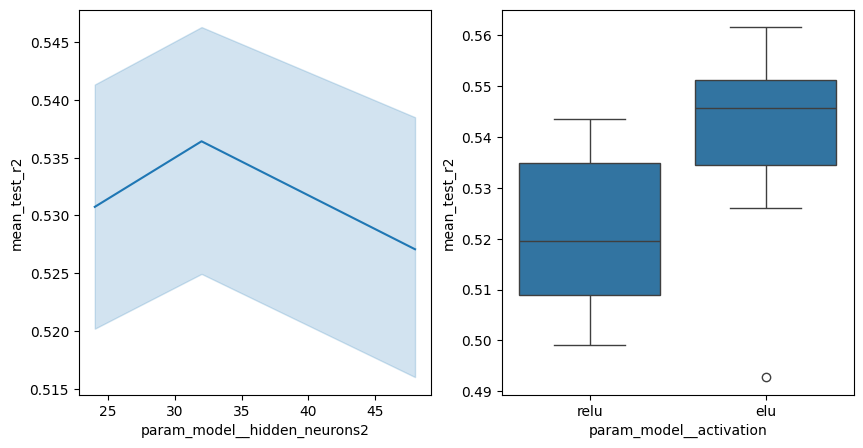

In [40]:
fig, ax = plt.subplots(1,2, figsize=(10,5))
sb.lineplot(data=keras_reg_cv_results7, x='param_model__hidden_neurons2', y='mean_test_r2', ax=ax[0])
sb.boxplot(data=keras_reg_cv_results7, x='param_model__activation', y='mean_test_r2', ax=ax[1])

In [41]:
keras_reg_scores_test7.describe()

,mean_absolute_error,mean_squared_error,r2
count,5.000000,5.000000,5.000000
mean,-1.556112,-4.657984,0.551881
std,0.061538,0.187949,0.012209
min,-1.661757,-4.965137,0.537369
25%,-1.553945,-4.690319,0.543036
50%,-1.538071,-4.614800,0.552008
75%,-1.515277,-4.518448,0.559169
max,-1.511511,-4.501216,0.567826


In [42]:
keras_reg_scores_train7.describe()

,mean_absolute_error,mean_squared_error,r2
count,5.000000,5.000000,5.000000
mean,-1.531101,-4.501618,0.566883
std,0.071879,0.164992,0.014578
min,-1.649975,-4.687458,0.549963
25%,-1.537611,-4.668893,0.552142
50%,-1.515076,-4.413440,0.575342
75%,-1.487738,-4.410986,0.576784
max,-1.465104,-4.327312,0.580185


In [43]:
keras_reg_estimators7

[KerasRegressor(
 	model=<function create_model4 at 0x000001EA91AD6A20>
 	build_fn=None
 	warm_start=False
 	random_state=None
 	optimizer=rmsprop
 	loss=None
 	metrics=None
 	batch_size=10
 	validation_batch_size=None
 	verbose=0
 	callbacks=None
 	validation_split=0.0
 	shuffle=True
 	run_eagerly=False
 	epochs=10
 	model__activation=elu
 	model__hidden_neurons2=32
 ),
 KerasRegressor(
 	model=<function create_model4 at 0x000001EA91AD6A20>
 	build_fn=None
 	warm_start=False
 	random_state=None
 	optimizer=rmsprop
 	loss=None
 	metrics=None
 	batch_size=10
 	validation_batch_size=None
 	verbose=0
 	callbacks=None
 	validation_split=0.0
 	shuffle=True
 	run_eagerly=False
 	epochs=10
 	model__activation=elu
 	model__hidden_neurons2=24
 ),
 KerasRegressor(
 	model=<function create_model4 at 0x000001EA91AD6A20>
 	build_fn=None
 	warm_start=False
 	random_state=None
 	optimizer=rmsprop
 	loss=None
 	metrics=None
 	batch_size=10
 	validation_batch_size=None
 	verbose=0
 	callbacks=None
 	va

In [44]:
keras_reg_param = {
    'batch_size': [10],
    'epochs': [20], 
    'model__hidden_neurons2': [32],
    'model__activation': ['elu'],
}
keras_model_estimators_final, keras_model__scores_train_final, keras_model_scores_test_final, keras_model_cv_results_final = train(features, targets, model_keras_model, keras_reg_param, outer_splits=5, inner_splits=4)

c:\Users\hallo\Documents\GitHub\praktisk-maskinlering\.venv\Lib\site-packages\sklearn\model_selection\_split.py:811: UserWarning: The least populated class in y has only 1 members, which is less than n_splits=5.
  warnings.warn(
c:\Users\hallo\Documents\GitHub\praktisk-maskinlering\.venv\Lib\site-packages\sklearn\model_selection\_split.py:811: UserWarning: The least populated class in y has only 1 members, which is less than n_splits=4.
  warnings.warn(


*


c:\Users\hallo\Documents\GitHub\praktisk-maskinlering\.venv\Lib\site-packages\sklearn\model_selection\_split.py:811: UserWarning: The least populated class in y has only 1 members, which is less than n_splits=4.
  warnings.warn(


*


c:\Users\hallo\Documents\GitHub\praktisk-maskinlering\.venv\Lib\site-packages\sklearn\model_selection\_split.py:811: UserWarning: The least populated class in y has only 1 members, which is less than n_splits=4.
  warnings.warn(


*


c:\Users\hallo\Documents\GitHub\praktisk-maskinlering\.venv\Lib\site-packages\sklearn\model_selection\_split.py:811: UserWarning: The least populated class in y has only 1 members, which is less than n_splits=4.
  warnings.warn(


*


c:\Users\hallo\Documents\GitHub\praktisk-maskinlering\.venv\Lib\site-packages\sklearn\model_selection\_split.py:811: UserWarning: The least populated class in y has only 1 members, which is less than n_splits=4.
  warnings.warn(


*


In [45]:
keras_model_scores_test_final.describe()

,mean_absolute_error,mean_squared_error,r2
count,5.000000,5.000000,5.000000
mean,-1.516680,-4.589551,0.558512
std,0.059046,0.201350,0.012314
min,-1.582379,-4.900817,0.543362
25%,-1.561084,-4.629000,0.552103
50%,-1.525704,-4.590872,0.555557
75%,-1.472618,-4.443184,0.567113
max,-1.441616,-4.383883,0.574425


In [46]:
keras_model__scores_train_final.describe()

,mean_absolute_error,mean_squared_error,r2
count,5.000000,5.000000,5.000000
mean,-1.495237,-4.417637,0.574938
std,0.041334,0.057504,0.004404
min,-1.530028,-4.484812,0.569419
25%,-1.527098,-4.463511,0.571983
50%,-1.513620,-4.418705,0.576141
75%,-1.470818,-4.367560,0.576280
max,-1.434622,-4.353599,0.580867


In [47]:
def create_model5(activation='elu', loss='mean_squared_error', hidden_neurons1=160, hidden_neurons2=32, dropout=0.1):
    input = Input(shape=(8,))
    x = (Dense(hidden_neurons1, activation=activation))(input)
    x = (Dense(hidden_neurons2, activation=activation))(x) + (Dense(hidden_neurons2, activation=activation))(input)
    x = (Dropout(dropout))(x)
    x = (Dense(8, activation=activation))(x)
    x = (Dense(1))(x)
    model = Model(inputs=input, outputs=x)
    model.compile(optimizer=Adam(learning_rate=0.005), loss=loss, metrics=['mean_squared_error'])
    return model

In [48]:
keras_reg_param = {
    'batch_size': [10],
    'epochs': [10], 
    'model__hidden_neurons2': [24, 32, 48],
    'model__dropout':[0.1, 0.15, 0.2],
}
model_keras_model_dropout = KerasRegressor(create_model5, verbose=0)
keras_reg_estimators8, keras_reg_scores_train8, keras_reg_scores_test8, keras_reg_cv_results8 = train(features, targets, model_keras_model_dropout, keras_reg_param, outer_splits=5, inner_splits=4)

c:\Users\hallo\Documents\GitHub\praktisk-maskinlering\.venv\Lib\site-packages\sklearn\model_selection\_split.py:811: UserWarning: The least populated class in y has only 1 members, which is less than n_splits=5.
  warnings.warn(
c:\Users\hallo\Documents\GitHub\praktisk-maskinlering\.venv\Lib\site-packages\sklearn\model_selection\_split.py:811: UserWarning: The least populated class in y has only 1 members, which is less than n_splits=4.
  warnings.warn(


*


c:\Users\hallo\Documents\GitHub\praktisk-maskinlering\.venv\Lib\site-packages\sklearn\model_selection\_split.py:811: UserWarning: The least populated class in y has only 1 members, which is less than n_splits=4.
  warnings.warn(


*


c:\Users\hallo\Documents\GitHub\praktisk-maskinlering\.venv\Lib\site-packages\sklearn\model_selection\_split.py:811: UserWarning: The least populated class in y has only 1 members, which is less than n_splits=4.
  warnings.warn(


*


c:\Users\hallo\Documents\GitHub\praktisk-maskinlering\.venv\Lib\site-packages\sklearn\model_selection\_split.py:811: UserWarning: The least populated class in y has only 1 members, which is less than n_splits=4.
  warnings.warn(


*


c:\Users\hallo\Documents\GitHub\praktisk-maskinlering\.venv\Lib\site-packages\sklearn\model_selection\_split.py:811: UserWarning: The least populated class in y has only 1 members, which is less than n_splits=4.
  warnings.warn(


*


<Axes: xlabel='param_model__dropout', ylabel='mean_test_r2'>

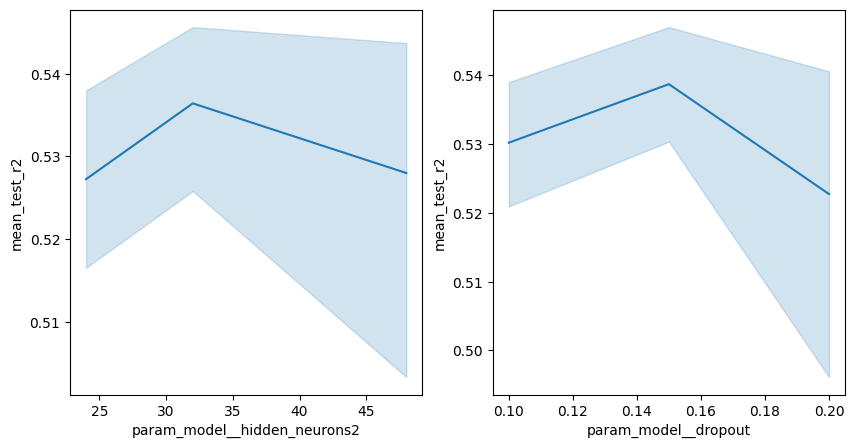

In [49]:
fig, ax = plt.subplots(1,2, figsize=(10,5))
sb.lineplot(data=keras_reg_cv_results8, x='param_model__hidden_neurons2', y='mean_test_r2', ax=ax[0])
sb.lineplot(data=keras_reg_cv_results8, x='param_model__dropout', y='mean_test_r2', ax=ax[1])

In [50]:
keras_reg_scores_test8.describe()

,mean_absolute_error,mean_squared_error,r2
count,5.000000,5.000000,5.000000
mean,-1.585123,-4.745768,0.543690
std,0.111799,0.396804,0.030742
min,-1.754035,-5.409973,0.495921
25%,-1.643170,-4.747020,0.537511
50%,-1.534060,-4.673078,0.544083
75%,-1.500173,-4.511331,0.566855
max,-1.494177,-4.387437,0.574079


In [51]:
keras_reg_scores_train8.describe()

,mean_absolute_error,mean_squared_error,r2
count,5.000000,5.000000,5.000000
mean,-1.565811,-4.627428,0.554679
std,0.101846,0.202944,0.021302
min,-1.727047,-4.946860,0.520079
25%,-1.597378,-4.653656,0.553603
50%,-1.536622,-4.631895,0.555297
75%,-1.495406,-4.471150,0.571250
max,-1.472601,-4.433580,0.573167


In [62]:
keras_reg_estimators8

[KerasRegressor(
 	model=<function create_model5 at 0x000001EBE093A8E0>
 	build_fn=None
 	warm_start=False
 	random_state=None
 	optimizer=rmsprop
 	loss=None
 	metrics=None
 	batch_size=10
 	validation_batch_size=None
 	verbose=0
 	callbacks=None
 	validation_split=0.0
 	shuffle=True
 	run_eagerly=False
 	epochs=10
 	model__dropout=0.15
 	model__hidden_neurons2=32
 ),
 KerasRegressor(
 	model=<function create_model5 at 0x000001EBE093A8E0>
 	build_fn=None
 	warm_start=False
 	random_state=None
 	optimizer=rmsprop
 	loss=None
 	metrics=None
 	batch_size=10
 	validation_batch_size=None
 	verbose=0
 	callbacks=None
 	validation_split=0.0
 	shuffle=True
 	run_eagerly=False
 	epochs=10
 	model__dropout=0.1
 	model__hidden_neurons2=24
 ),
 KerasRegressor(
 	model=<function create_model5 at 0x000001EBE093A8E0>
 	build_fn=None
 	warm_start=False
 	random_state=None
 	optimizer=rmsprop
 	loss=None
 	metrics=None
 	batch_size=10
 	validation_batch_size=None
 	verbose=0
 	callbacks=None
 	validat

In [65]:
keras_reg_param = {
    'batch_size': [10],
    'epochs': [10], 
    'model__hidden_neurons2': [32],
    'model__dropout':[0.10, 0.15, 0.2],
}
keras_reg_estimators9, keras_reg_scores_train9, keras_reg_scores_test9, keras_reg_cv_results9 = train(features, targets, model_keras_model_dropout, keras_reg_param, outer_splits=5, inner_splits=4)

c:\Users\hallo\Documents\GitHub\praktisk-maskinlering\.venv\Lib\site-packages\sklearn\model_selection\_split.py:811: UserWarning: The least populated class in y has only 1 members, which is less than n_splits=5.
  warnings.warn(
c:\Users\hallo\Documents\GitHub\praktisk-maskinlering\.venv\Lib\site-packages\sklearn\model_selection\_split.py:811: UserWarning: The least populated class in y has only 1 members, which is less than n_splits=4.
  warnings.warn(


*


c:\Users\hallo\Documents\GitHub\praktisk-maskinlering\.venv\Lib\site-packages\sklearn\model_selection\_split.py:811: UserWarning: The least populated class in y has only 1 members, which is less than n_splits=4.
  warnings.warn(


*


c:\Users\hallo\Documents\GitHub\praktisk-maskinlering\.venv\Lib\site-packages\sklearn\model_selection\_split.py:811: UserWarning: The least populated class in y has only 1 members, which is less than n_splits=4.
  warnings.warn(


*


c:\Users\hallo\Documents\GitHub\praktisk-maskinlering\.venv\Lib\site-packages\sklearn\model_selection\_split.py:811: UserWarning: The least populated class in y has only 1 members, which is less than n_splits=4.
  warnings.warn(


*


c:\Users\hallo\Documents\GitHub\praktisk-maskinlering\.venv\Lib\site-packages\sklearn\model_selection\_split.py:811: UserWarning: The least populated class in y has only 1 members, which is less than n_splits=4.
  warnings.warn(


*


<Axes: xlabel='param_model__dropout', ylabel='mean_test_r2'>

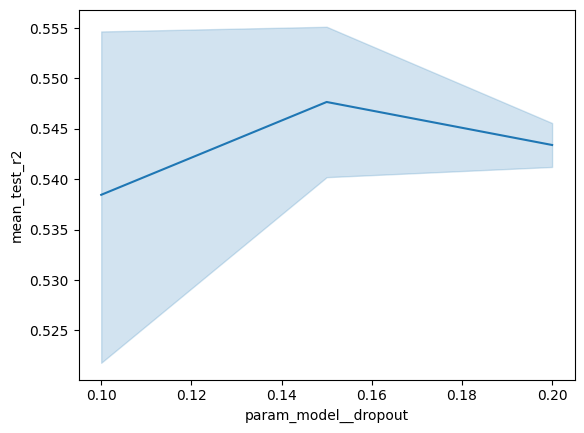

In [67]:
sb.lineplot(data=keras_reg_cv_results9, x='param_model__dropout', y='mean_test_r2')

In [68]:
keras_reg_scores_test9.describe()

,mean_absolute_error,mean_squared_error,r2
count,5.000000,5.000000,5.000000
mean,-1.549406,-4.843009,0.533968
std,0.080906,0.187931,0.016638
min,-1.636159,-5.031603,0.517358
25%,-1.621444,-4.947001,0.520487
50%,-1.552083,-4.921760,0.531176
75%,-1.483238,-4.756693,0.543297
max,-1.454106,-4.557985,0.557523


In [69]:
keras_reg_scores_train9.describe()

,mean_absolute_error,mean_squared_error,r2
count,5.000000,5.000000,5.000000
mean,-1.517594,-4.628075,0.554732
std,0.050191,0.192073,0.016839
min,-1.580959,-4.877619,0.532120
25%,-1.556156,-4.741987,0.544728
50%,-1.501407,-4.581141,0.558961
75%,-1.492561,-4.569873,0.561784
max,-1.456885,-4.369754,0.576067


In [71]:
keras_reg_estimators9

[KerasRegressor(
 	model=<function create_model5 at 0x000001EBE093A8E0>
 	build_fn=None
 	warm_start=False
 	random_state=None
 	optimizer=rmsprop
 	loss=None
 	metrics=None
 	batch_size=10
 	validation_batch_size=None
 	verbose=0
 	callbacks=None
 	validation_split=0.0
 	shuffle=True
 	run_eagerly=False
 	epochs=10
 	model__dropout=0.15
 	model__hidden_neurons2=32
 ),
 KerasRegressor(
 	model=<function create_model5 at 0x000001EBE093A8E0>
 	build_fn=None
 	warm_start=False
 	random_state=None
 	optimizer=rmsprop
 	loss=None
 	metrics=None
 	batch_size=10
 	validation_batch_size=None
 	verbose=0
 	callbacks=None
 	validation_split=0.0
 	shuffle=True
 	run_eagerly=False
 	epochs=10
 	model__dropout=0.15
 	model__hidden_neurons2=32
 ),
 KerasRegressor(
 	model=<function create_model5 at 0x000001EBE093A8E0>
 	build_fn=None
 	warm_start=False
 	random_state=None
 	optimizer=rmsprop
 	loss=None
 	metrics=None
 	batch_size=10
 	validation_batch_size=None
 	verbose=0
 	callbacks=None
 	valida

In [76]:
keras_reg_param = {
    'batch_size': [10],
    'epochs': [20], 
    'model__hidden_neurons2': [32],
    'model__dropout':[0.10],
}
keras_model_dropout_estimators_final, keras_model_dropout_scores_train_final, keras_model_dropout_scores_test_final, keras_model_dropout_cv_results_final = train(features, targets, model_keras_model_dropout, keras_reg_param, outer_splits=5, inner_splits=4)

c:\Users\hallo\Documents\GitHub\praktisk-maskinlering\.venv\Lib\site-packages\sklearn\model_selection\_split.py:811: UserWarning: The least populated class in y has only 1 members, which is less than n_splits=5.
  warnings.warn(
c:\Users\hallo\Documents\GitHub\praktisk-maskinlering\.venv\Lib\site-packages\sklearn\model_selection\_split.py:811: UserWarning: The least populated class in y has only 1 members, which is less than n_splits=4.
  warnings.warn(


*


c:\Users\hallo\Documents\GitHub\praktisk-maskinlering\.venv\Lib\site-packages\sklearn\model_selection\_split.py:811: UserWarning: The least populated class in y has only 1 members, which is less than n_splits=4.
  warnings.warn(


*


c:\Users\hallo\Documents\GitHub\praktisk-maskinlering\.venv\Lib\site-packages\sklearn\model_selection\_split.py:811: UserWarning: The least populated class in y has only 1 members, which is less than n_splits=4.
  warnings.warn(


*


c:\Users\hallo\Documents\GitHub\praktisk-maskinlering\.venv\Lib\site-packages\sklearn\model_selection\_split.py:811: UserWarning: The least populated class in y has only 1 members, which is less than n_splits=4.
  warnings.warn(


*


c:\Users\hallo\Documents\GitHub\praktisk-maskinlering\.venv\Lib\site-packages\sklearn\model_selection\_split.py:811: UserWarning: The least populated class in y has only 1 members, which is less than n_splits=4.
  warnings.warn(


*


In [78]:
keras_model_dropout_scores_test_final.describe()

,mean_absolute_error,mean_squared_error,r2
count,5.000000,5.000000,5.000000
mean,-1.530728,-4.669435,0.550750
std,0.077594,0.254459,0.021417
min,-1.623155,-4.976183,0.521147
25%,-1.600964,-4.914989,0.536340
50%,-1.509040,-4.520523,0.558967
75%,-1.470254,-4.490854,0.564040
max,-1.450230,-4.444624,0.573259


In [79]:
keras_model_dropout_scores_train_final.describe()

,mean_absolute_error,mean_squared_error,r2
count,5.000000,5.000000,5.000000
mean,-1.516742,-4.493621,0.567645
std,0.059838,0.234184,0.021786
min,-1.596249,-4.864666,0.533362
25%,-1.561192,-4.522061,0.565843
50%,-1.497803,-4.432882,0.570824
75%,-1.472964,-4.423798,0.574920
max,-1.455504,-4.224696,0.593277


In [93]:
slutt_resultat = pd.DataFrame({
    'Metric': ['Mean absolute error:','Mean squared error:','r2:'],
    'Keras Sequential Train': [keras_sequential_scores_train_final["mean_absolute_error"].mean(), keras_sequential_scores_train_final["mean_squared_error"].mean(), keras_sequential_scores_train_final['r2'].mean()],
    'Keras Sequential Test': [keras_sequential_scores_test_final["mean_absolute_error"].mean(), keras_sequential_scores_test_final["mean_squared_error"].mean(), keras_sequential_scores_test_final['r2'].mean()],
    'Keras Sequential Dropout Train': [model_keras_sequential_dropout_scores_train_final["mean_absolute_error"].mean(), model_keras_sequential_dropout_scores_train_final["mean_squared_error"].mean(), model_keras_sequential_dropout_scores_train_final['r2'].mean()],
    'Keras Sequential Dropout Test': [model_keras_sequential_dropout_scores_test_final["mean_absolute_error"].mean(), model_keras_sequential_dropout_scores_test_final["mean_squared_error"].mean(), model_keras_sequential_dropout_scores_test_final['r2'].mean()],
    'Keras Model Train': [keras_model__scores_train_final["mean_absolute_error"].mean(), keras_model__scores_train_final["mean_squared_error"].mean(), keras_model__scores_train_final['r2'].mean()],
    'Keras Model Test': [keras_model_scores_test_final["mean_absolute_error"].mean(), keras_model_scores_test_final["mean_squared_error"].mean(), keras_model_scores_test_final['r2'].mean()],
    'Keras Model Dropout Train': [keras_model_dropout_scores_train_final["mean_absolute_error"].mean(), keras_model_dropout_scores_train_final["mean_squared_error"].mean(), keras_model_dropout_scores_train_final['r2'].mean()],
    'Keras Model Dropout Test': [keras_model_dropout_scores_test_final["mean_absolute_error"].mean(), keras_model_dropout_scores_test_final["mean_squared_error"].mean(), keras_model_dropout_scores_test_final['r2'].mean()],
})
slutt_resultat.set_index('Metric', inplace=True)
slutt_resultat

,Keras Sequential Train,Keras Sequential Test,Keras Sequential Dropout Train,Keras Sequential Dropout Test,Keras Model Train,Keras Model Test,Keras Model Dropout Train,Keras Model Dropout Test
Metric,,,,,,,,
Mean absolute error:,-1.597413,-1.626969,-1.510741,-1.509980,-1.495237,-1.516680,-1.516742,-1.530728
Mean squared error:,-4.934826,-5.445882,-4.612454,-4.690475,-4.417637,-4.589551,-4.493621,-4.669435
r2:,0.525084,0.475847,0.556226,0.548718,0.574938,0.558512,0.567645,0.550750
